In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### Overall accuracy of the 2-way classifiers

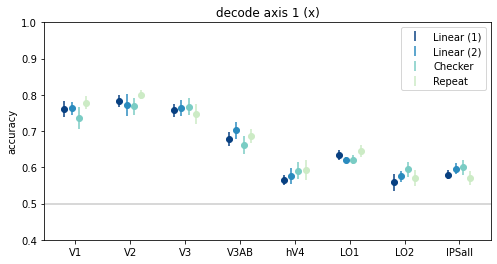

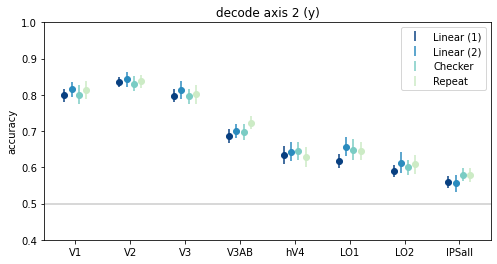

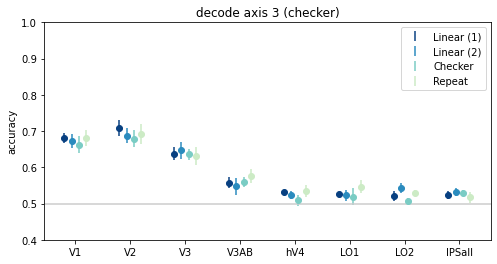

In [5]:
ti_plot = [0,1,2,3]
x_jitter = np.linspace(-0.2, 0.2, 4)

for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)', 'axis 3 (checker)']):

    plt.figure(figsize=(8,4));
    
    avals = dec_withintask['acc_bytask'][:,:,:,bi]

    plt.axhline(1/2, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0.4, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)


#### visualize classifier output for one ROI

In [6]:
si = 5; ss=subjects[si]
ri = 0;
ti = 1; tt = 2;
ii = 1;

prob = dec_withintask['probs_all'][si][ri][ti][ii]
# "confidence" in assignment to category 2 vs 1
# NOTE here prob[:,0] corresponds to coord>center
# and prob[:,1] corresponds to coord<center
# which is different from order in ordinal classifeir
pdiff = prob[:,0] - prob[:,1]

# get info about individual trials
l = lab[ss][lab[ss]['task']==tt]

pt_labs = np.array([l['ptx'], l['pty']]).T
is_main_grid = l['is_main_grid']==1
# actual labels for position along this axis
coord_actual = pt_labs[:,ii]
# is it a hard trial?
is_hard = ~is_main_grid

# which side of boundary was point? 1 = >center, 2 = <center
categ_actual = np.array(l['category_unmapped']).astype(int)
categ_check = grid_utils.get_categ(pt_labs, tt)
assert(np.all(categ_actual==categ_check))

# what category did the subject respond? 
categ_subjresp = np.array(l['resp_unmapped']).astype(int)
categ_subjresp[np.abs(categ_subjresp)>2] = 0;

# was the subject correct or incorrect?
correct = categ_subjresp==categ_actual
assert(np.all(correct==l['subject_correct']))

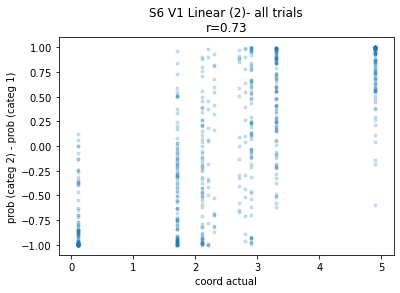

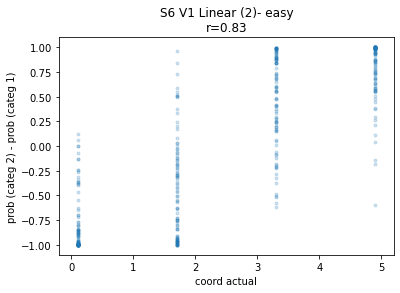

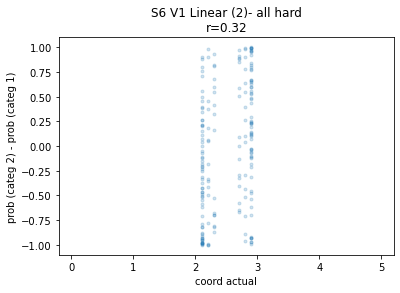

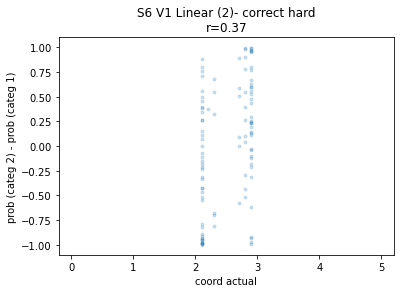

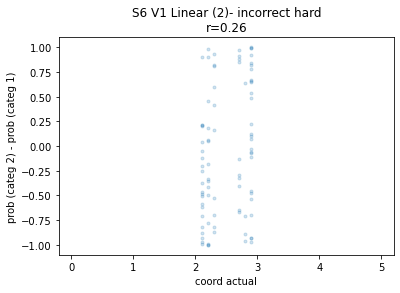

In [7]:

for inds, name in zip([np.ones(np.shape(is_hard),dtype=bool), \
                       ~is_hard, is_hard, is_hard & correct, is_hard & ~correct], \
                      ['all trials', 'easy', 'all hard','correct hard','incorrect hard']):
    plt.figure()

    plt.plot(coord_actual[inds], pdiff[inds], '.', alpha=0.2)
    plt.xlabel('coord actual')
    plt.ylabel('prob (categ 2) - prob (categ 1)')
    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
    plt.title('S%d %s %s- %s\nr=%.2f'%(subjects[si], roi_names[ri], task_names[ti], name, r));
    plt.xlim([-0.2, 5.2])
    plt.ylim([-1.1, 1.1])